# CS542 - Class Challenge - fine-grained classification of plants:

Our class challenge will consists of two tasks addressing an image recognition task where our dataset contains about 1K categories of plants with only about 250,000 images.  There will be two parts to this task:

1. Image classification. Imagine we have cateloged all the plants we care to identify, now we just need to create a classifier for them! Use your skills from the supervised learning sections of this course to try to address this problem.

2. Semi-Supervised/Few-Shot Learning.  Unfortunately, we missed some important plants we want to classify!  We do have some images we think contain the plant, but we have only have a few labels.  Our new goal is to develop an AI model that can learn from just these labeled examples.

Each student must submit a model on both tasks.  Students in the top 3 on each task will get 5% extra credit on this assignment.

This notebook is associated with the first task (image classification).


# Dataset
The dataset is downloaded on scc in the address: "/projectnb2/cs542-bap/classChallenge/data". You can find the python version of this notebook there as well or you could just type "jupyter nbconvert --to script baselineModel_task1.ipynb" and it will output "baselineModel_task1.py". You should be able to run "baselineModel_task1.py" on scc by simply typing "python baselineModel_task1.py"

Please don't try to change or delete the dataset.

# Evaluation:
You will compete with each other over your performance on the dedicated test set. The performance measure is top the 5 error, i.e: if the true class is in one of your top 5 likely predictions, then its error is 0, otherwise its error is 1.  So, your goal is to get an error of 0. This notebook outputs top5 accuracy, so it is 1 - top5 error.

# Baseline:
The following code is a baseline which you can use and improve to come up with your model for this task

# Suggestion
One simple suggestion would be to use a pretrained model on imagenet and finetune it on this data similar to this [link](https://keras.io/api/applications/)
Also you should likely train more than 2 epochs.

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Download the dataset (may need to be rerun)

In [2]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1p5wZTr2o5W4kRQfC8ORawwhP9oIMT7Y3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1p5wZTr2o5W4kRQfC8ORawwhP9oIMT7Y3" -O data.zip && rm -rf /tmp/cookies.txt

import zipfile

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

--2020-12-06 22:50:23--  https://docs.google.com/uc?export=download&confirm=9Qvb&id=1p5wZTr2o5W4kRQfC8ORawwhP9oIMT7Y3
Resolving docs.google.com (docs.google.com)... 142.250.97.139, 142.250.97.100, 142.250.97.113, ...
Connecting to docs.google.com (docs.google.com)|142.250.97.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-3s-docs.googleusercontent.com/docs/securesc/be1r2hrsd0pi0g482pg8pr0b915rnvbj/s3rmrruj7sl51naasph0vbcpl3ddl4sc/1607295000000/16959996596808468099/11995804591229286456Z/1p5wZTr2o5W4kRQfC8ORawwhP9oIMT7Y3?e=download [following]
--2020-12-06 22:50:23--  https://doc-0c-3s-docs.googleusercontent.com/docs/securesc/be1r2hrsd0pi0g482pg8pr0b915rnvbj/s3rmrruj7sl51naasph0vbcpl3ddl4sc/1607295000000/16959996596808468099/11995804591229286456Z/1p5wZTr2o5W4kRQfC8ORawwhP9oIMT7Y3?e=download
Resolving doc-0c-3s-docs.googleusercontent.com (doc-0c-3s-docs.googleusercontent.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting

## Explore the dataset

In [3]:
import pathlib
data_dir = 'data/'
image_dir = os.path.join(data_dir, 'images_32x32')
image_dir = pathlib.Path(image_dir)
image_count = len(list(image_dir.glob('*.jpg')))
print("Total number of images = ",image_count)

Total number of images =  268242


## Here are some images

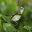

In [4]:
PIL.Image.open(os.path.join(image_dir, '100.jpg'))
# note they are now 32x32 images

# Create a dataset

In [5]:
train_ds = tf.data.TextLineDataset(os.path.join(data_dir, 'train_50_classes.txt'))
val_ds = tf.data.TextLineDataset(os.path.join(data_dir, 'val_50_classes.txt'))

with open(os.path.join(data_dir, 'classes_50_subset.txt'), 'r') as f:
  class_names = [c.strip() for c in f.readlines()]

num_classes = len(class_names)

## Write a short function that converts a file path to an (img, label) pair:

In [6]:
def decode_img(img, crop_size=32):
  img = tf.io.read_file(img)
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [crop_size, crop_size])

def get_label(label):
  # find teh matching label
  one_hot = tf.where(tf.equal(label, class_names))
  # Integer encode the label
  return tf.reduce_min(one_hot)

def process_path(file_path):
  # should have two parts
  file_path = tf.strings.split(file_path)
  # second part has the class index
  label = get_label(file_path[1])
  # load the raw data from the file
  img = decode_img(tf.strings.join([data_dir, 'images_32x32/', file_path[0], '.jpg']))
  return img, label

def process_path_test(file_path):
  # load the raw data from the file
  img = decode_img(tf.strings.join([data_dir, 'images_32x32/', file_path, '.jpg']))
  return img, file_path

## Finish setting up data

In [7]:
batch_size = 32

In [8]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [9]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (32, 32, 3)
Label:  41


## Data loader hyper-parameters for performance!

In [10]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## Here are some resized images ready to use!

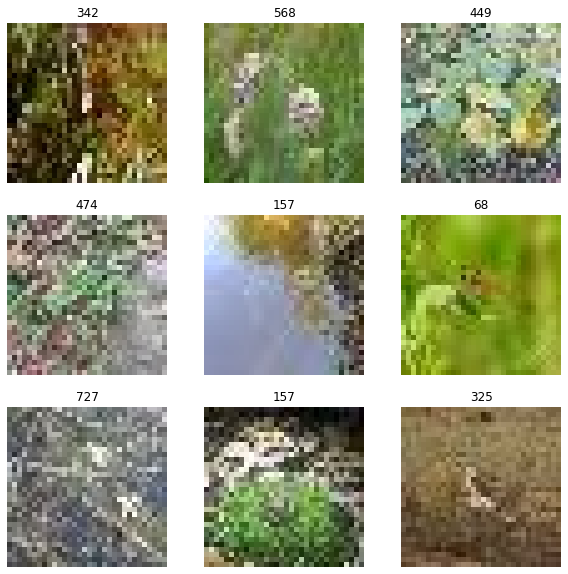

In [11]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## A simple CNN model!

In [12]:
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3),
  layers.Conv2D(128, 3),
  layers.Conv2D(256, 3),
  layers.Flatten(),
  layers.Dense(512),
  layers.Dense(num_classes)
])

print(num_classes)

50


## The usual loss function

In [13]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)])

## Training

In [14]:
model.fit(train_ds,validation_data=val_ds,epochs=2,shuffle=True)

Epoch 1/2
292/292 [==============================] - 500s 2s/step - loss: 3.5226 - accuracy: 0.1311 - sparse_top_k_categorical_accuracy: 0.3768 - val_loss: 3.2972 - val_accuracy: 0.1476 - val_sparse_top_k_categorical_accuracy: 0.4335
Epoch 2/2
292/292 [==============================] - 495s 2s/step - loss: 2.7555 - accuracy: 0.2773 - sparse_top_k_categorical_accuracy: 0.6102 - val_loss: 3.6141 - val_accuracy: 0.1261 - val_sparse_top_k_categorical_accuracy: 0.3891
